# Objetivo

Sugerir novos clientes para um portifólio de entrada

# Método
Com uma base de mais de 460.000 clientes o sistema desenvolvido nesse documento sugere possíveis leads para um portfólio de clientes fornecido como entrada.
As etapas de implementação do sistema contemplam a leitura da base com a biblioteca `pandas`, o preenchimento de valores nulos de acordo com sua categoria, na sequência codifica atráves do método de `LabelEncoder` as componentes para possibilitar a utilizaçaõ do algoritmo `NearestNeihghbors`, o qual possibilita o cálculo da distância entre o cliente de entrada e os clientes mais próximos. Estes últimos estão presentes na biblioteca `scikit learn`.
Os resultados são apresentados com a biblioteca `folium` em um mapa do Brasil, onde os clientes atuais e sugeridos são apresentados, em marcadorse azuis e verdes, respectivamente, que fornecem informações de identificação e setor de operação ao selecionar cada marcador com o mouse. Além da representação geográfica é apresentado um gráfico das sugestões agrupado pelo faturamento e ramo de atuação.
    

# Leitura dos arquivos

In [2]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# preprocessing
from sklearn import preprocessing

#Unsupervised Learning
from sklearn.neighbors import NearestNeighbors

#Imports para Visualizações
import folium
from folium import plugins
import random

## Leitura da lista de features a excluir

# Carregamento da Base 

In [21]:
base = pd.read_feather('../estaticos_market.feather')
base.set_index('id',inplace=True)
base.head()

,fl_matriz,de_natureza_juridica,sg_uf,natureza_juridica_macro,de_ramo,setor,idade_empresa_anos,idade_emp_cat,fl_me,fl_sa,...,nm_meso_regiao,nm_micro_regiao,fl_passivel_iss,qt_socios,idade_media_socios,qt_socios_feminino,de_faixa_faturamento_estimado,de_faixa_faturamento_estimado_grupo,vl_faturamento_estimado_aux,vl_faturamento_estimado_grupo_aux
id,,,,,,,,,,,,,,,,,,,,,
a6984c3ae395090e3bee8ad63c3758b110de096d5d819583a784a113726db849,True,SOCIEDADE EMPRESARIA LIMITADA,RN,ENTIDADES EMPRESARIAIS,INDUSTRIA DA CONSTRUCAO,CONSTRUÇÃO CIVIL,14.457534,10 a 15,False,False,...,LESTE POTIGUAR,NATAL,True,2.0,44.0,NaN,"DE R$ 1.500.000,01 A R$ 4.800.000,00","DE R$ 1.500.000,01 A R$ 4.800.000,00",3132172.8,3132172.8
6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c47fdef50b33f4f56f05,True,EMPRESARIO INDIVIDUAL,PI,OUTROS,SERVICOS DE ALOJAMENTO/ALIMENTACAO,SERVIÇO,1.463014,1 a 5,False,False,...,CENTRO NORTE PIAUIENSE,TERESINA,True,1.0,27.0,NaN,"DE R$ 81.000,01 A R$ 360.000,00","DE R$ 81.000,01 A R$ 360.000,00",210000.0,210000.0
4a7e5069a397f12fdd7fd57111d6dc5d3ba558958efc02edc5147bc2a2535b08,True,EMPRESARIO INDIVIDUAL,AM,OUTROS,"TRANSPORTE, ARMAZENAGEM E CORREIO",SERVIÇO,7.093151,5 a 10,False,False,...,CENTRO AMAZONENSE,MANAUS,True,1.0,32.0,NaN,"ATE R$ 81.000,00","ATE R$ 81.000,00",50000.0,50000.0
3348900fe63216a439d2e5238c79ddd46ede454df7b9d8c24ac33eb21d4b21ef,True,EMPRESARIO INDIVIDUAL,AM,OUTROS,SERVICOS DIVERSOS,SERVIÇO,6.512329,5 a 10,False,False,...,CENTRO AMAZONENSE,MANAUS,True,1.0,36.0,NaN,"DE R$ 81.000,01 A R$ 360.000,00","DE R$ 81.000,01 A R$ 360.000,00",210000.0,210000.0
1f9bcabc9d3173c1fe769899e4fac14b053037b953a1e4b102c769f7611ab29f,True,EMPRESARIO INDIVIDUAL,RN,OUTROS,"SERVICOS PROFISSIONAIS, TECNICOS E CIENTIFICOS",SERVIÇO,3.200000,1 a 5,False,False,...,LESTE POTIGUAR,NATAL,True,1.0,NaN,NaN,"DE R$ 81.000,01 A R$ 360.000,00","DE R$ 81.000,01 A R$ 360.000,00",210000.0,210000.0


# Trabalhando com os valores inexistentes


### Inicialmente identificar como serão preenchidos os NaNs de acordo com seu tipo

In [145]:
fill_dict = base.dtypes.to_dict()
# Categorias em que existiam NaNs e são categóricas, mas deveriam ser booleans
cat2bool = ['fl_optante_simei','fl_optante_simples','fl_passivel_iss']

for feature in fill_dict:
    if(fill_dict[feature] == bool):
        fill_dict[feature] = False
    elif(fill_dict[feature] == object):
        fill_dict[feature] = 'other'
    else:
        fill_dict[feature] = 0
    if feature in cat2bool:
        fill_dict[feature] = False
        
fill_dict

{'fl_matriz': 0,
 'de_natureza_juridica': 'other',
 'sg_uf': 'other',
 'natureza_juridica_macro': 'other',
 'de_ramo': 'other',
 'setor': 'other',
 'idade_empresa_anos': 0,
 'idade_emp_cat': 'other',
 'fl_me': 0,
 'fl_sa': 0,
 'fl_mei': 0,
 'fl_ltda': 0,
 'dt_situacao': 'other',
 'fl_st_especial': 0,
 'fl_email': 0,
 'fl_telefone': 0,
 'fl_rm': 'other',
 'nm_divisao': 'other',
 'nm_segmento': 'other',
 'fl_optante_simples': False,
 'fl_optante_simei': False,
 'sg_uf_matriz': 'other',
 'de_saude_tributaria': 'other',
 'de_saude_rescencia': 'other',
 'nu_meses_rescencia': 0,
 'de_nivel_atividade': 'other',
 'empsetorcensitariofaixarendapopulacao': 0,
 'nm_meso_regiao': 'other',
 'nm_micro_regiao': 'other',
 'fl_passivel_iss': False,
 'qt_socios': 0,
 'idade_media_socios': 0,
 'qt_socios_feminino': 0,
 'de_faixa_faturamento_estimado': 'other',
 'de_faixa_faturamento_estimado_grupo': 'other',
 'vl_faturamento_estimado_aux': 0,
 'vl_faturamento_estimado_grupo_aux': 0}

### Executando o preenchimento de NaNs

In [24]:
base.fillna(value=fill_dict, inplace=True)
base[cat2bool] = base[cat2bool].astype(bool)
bool2numeric = base.columns[base.dtypes == bool]

base[bool2numeric] = base[bool2numeric].astype(int)

# Encoding

In [25]:
cat = base.columns[base.dtypes == object]
not_cat = base.columns[base.dtypes != object]

In [26]:
# Usando LabelEncoder
#https://chrisalbon.com/machine_learning/preprocessing_structured_data/convert_pandas_categorical_column_into_integers_for_scikit-learn/

# Create a label (category) encoder object
le = preprocessing.LabelEncoder()

In [159]:
base_le = pd.DataFrame()
base_le[cat] = base[cat].apply(lambda col: le.fit_transform(col))
base_encoded = pd.concat([base[not_cat],base_le], axis =1)
base_encoded.head()


,fl_matriz,idade_empresa_anos,fl_me,fl_sa,fl_mei,fl_ltda,fl_st_especial,fl_email,fl_telefone,fl_optante_simples,...,nm_divisao,nm_segmento,sg_uf_matriz,de_saude_tributaria,de_saude_rescencia,de_nivel_atividade,nm_meso_regiao,nm_micro_regiao,de_faixa_faturamento_estimado,de_faixa_faturamento_estimado_grupo
id,,,,,,,,,,,,,,,,,,,,,
a6984c3ae395090e3bee8ad63c3758b110de096d5d819583a784a113726db849,1,14.457534,0,0,0,0,0,1,1,1,...,32,10,19,4,0,0,6,48,2,2
6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c47fdef50b33f4f56f05,1,1.463014,0,0,1,0,0,1,1,0,...,3,3,16,2,1,1,4,69,10,10
4a7e5069a397f12fdd7fd57111d6dc5d3ba558958efc02edc5147bc2a2535b08,1,7.093151,0,0,1,0,0,0,1,1,...,86,20,2,0,0,2,2,43,1,1
3348900fe63216a439d2e5238c79ddd46ede454df7b9d8c24ac33eb21d4b21ef,1,6.512329,0,0,0,0,0,1,1,1,...,74,17,2,0,0,2,2,43,10,10
1f9bcabc9d3173c1fe769899e4fac14b053037b953a1e4b102c769f7611ab29f,1,3.200000,0,0,0,0,0,1,1,1,...,77,8,19,4,0,0,6,48,10,10


# Nearest Neighbors 

Como não temos o que prever, usamos o treinamento não supervisionado do Nearest Neighbors



In [31]:
%%time

qtd_neighbors = 5
nearest = NearestNeighbors(n_neighbors=qtd_neighbors, metric = 'cosine')

nearest.fit(base_encoded)


CPU times: user 111 ms, sys: 236 ms, total: 347 ms
Wall time: 491 ms


## Procurando por sugestões

Lendo o arquivo portifolio de clientes, e associando com os dados já tratados

In [51]:
port = pd.read_csv('clientes2_merge.csv',usecols = ['id'])
port.set_index('id',inplace=True)

port_le = base_encoded.merge(port, how='right',left_index=True,right_index=True)
port = base.merge(port, how='right',left_index=True,right_index=True)

### Calculando os vizinhos mais próximos para o portifolio de clientes

In [32]:
%%time
neighbors_list = {}

for row in range(port_le.shape[0]):
    #print(row)
    neighbors_list[row] = nearest.kneighbors(port_le.iloc[[row]].values)

CPU times: user 3min 24s, sys: 2min 19s, total: 5min 43s
Wall time: 2min 28s


### A resposta é uma lista da distância e uma lista dos respectivos clientes

In [33]:
neighbors_list

{0: (array([[0.00000000e+00, 1.63313807e-13, 3.18411963e-13, 8.56315019e-13,
          1.52167168e-12]]),
  array([[  1646,   8626,  95246,  51124, 439410]])),
 1: (array([[0.00000000e+00, 2.50133247e-13, 9.54458734e-13, 1.33559830e-12,
          1.38555833e-12]]),
  array([[  2696, 325674,   4564,  22688, 301752]])),
 2: (array([[3.33066907e-16, 1.04161124e-12, 2.79498646e-12, 4.87887508e-12,
          6.24167384e-12]]),
  array([[  3681,   6066, 424650,  29452, 105545]])),
 3: (array([[3.33066907e-16, 1.57873714e-13, 3.94684285e-13, 4.20885549e-13,
          6.11510842e-13]]),
  array([[  4564, 301752, 439410, 325674, 402582]])),
 4: (array([[2.22044605e-16, 1.04161124e-12, 1.62092562e-12, 2.19280150e-12,
          5.54656321e-12]]),
  array([[  6066,   3681, 424650,  29452, 105545]])),
 5: (array([[0.00000000e+00, 3.08387760e-11, 4.37001546e-11, 4.58292293e-11,
          4.77013984e-11]]),
  array([[  6345,  26577, 253044, 356504, 189784]])),
 6: (array([[0.00000000e+00, 3.56176200e

# Avaliação

Agora com o NN funcionando, precisamos analisar as sugestões.

## Analisando as sugestões


Da lista de vizinhos, filtrar os clientes pertencentes ao portifólio de entrada.

In [147]:
list_size = len(neighbors_list)
num_neighbors = len(neighbors_list[0][1][0])

neighbors_idx_array = neighbors_list[0][1][0]
neighbors_distance_array = neighbors_list[0][0][0]
np.delete(neighbors_idx_array, [0,1])
np.delete(neighbors_distance_array, [0,1])
for line in range(1,list_size):
    neighbors_idx_array = np.concatenate((neighbors_idx_array, neighbors_list[line][1][0]), axis=None) 
    neighbors_distance_array = np.concatenate((neighbors_distance_array, neighbors_list[line][0][0]), axis=None) 

if len(neighbors_idx_array) != list_size*num_neighbors:
    print("ERROR: Check array size.")
# Temos agora um array unidimensional com os índices dos clientes recomendados)

Como esperado, o cliente mais próximo é ele mesmo

In [148]:
neighbors_distance_array[0]

0.0

Criar um dicionário com o id de origem da requisição, id do vizinho e distância entre eles

In [149]:
dicio = {}
for idx,ind in zip(neighbors_idx_array, range(len(neighbors_idx_array))):
    dicio[ind] = (port.iloc[int(ind/qtd_neighbors)].name, base.iloc[idx].name, (neighbors_distance_array[ind]))

In [150]:
dicio

{0: ('09e95c1a84049001d086470a8f320a19b076f955a89122ff8360ac2e4d6eca5d',
  '09e95c1a84049001d086470a8f320a19b076f955a89122ff8360ac2e4d6eca5d',
  0.0),
 1: ('09e95c1a84049001d086470a8f320a19b076f955a89122ff8360ac2e4d6eca5d',
  '194e619cb6417f92f75653406cf04106debc5035f13a8850b00428fd34d91d72',
  1.6331380692236053e-13),
 2: ('09e95c1a84049001d086470a8f320a19b076f955a89122ff8360ac2e4d6eca5d',
  'cf5abf9d1a1b5912e1fe2825f6130fdaa50a313a0d68f3693f675ad1d7e60bfc',
  3.184119634624949e-13),
 3: ('09e95c1a84049001d086470a8f320a19b076f955a89122ff8360ac2e4d6eca5d',
  'a74b4b5172bafa295c4d2ef1548da7ccfe3d5e3502d632a077b730f415793905',
  8.563150188933832e-13),
 4: ('09e95c1a84049001d086470a8f320a19b076f955a89122ff8360ac2e4d6eca5d',
  '980ad70b2ba1aed92c6106505f630fc7477e587e9ebac378d073bbb92d305e94',
  1.5216716775512396e-12),
 5: ('dc9d155f5bcd3172031e2ec9431786e8871ff4b0ff4728bb62194ca0842cce3e',
  'dc9d155f5bcd3172031e2ec9431786e8871ff4b0ff4728bb62194ca0842cce3e',
  0.0),
 6: ('dc9d155f5bcd31

### Criando um DataFrame com as sugestões

In [39]:
neig_df = pd.DataFrame.from_dict(dicio,orient='index')
neig_df.rename(columns={0:'id_origin', 1:'id',2:'distance'},inplace = True)
neig_df.set_index('id', inplace=True)

### Identificando os conflitos e removendo da lista de sugestões

In [40]:
conflicts = neig_df.merge(port, how='inner',left_index=True,right_index=True)
suggestion_with_conflicts = neig_df.merge(base, how='left',left_index=True,right_index=True)

suggestions = suggestion_with_conflicts.drop(conflicts.index)

In [42]:
len(conflicts.index.unique()), conflicts.shape, suggestion_with_conflicts.shape, port.shape, suggestions.shape

(566, (1202, 2), (2830, 39), (566, 0), (1628, 39))

# Visualização dos resultados

## Mapa (Heat)

### Carrega arquivo com informações geográficas
Gerado por `analysis/Save_IBGE_data_for_Map_Visualization_in_Recommendation_System.ipynb`

In [151]:
coord_micro = pd.read_csv('../recommender_system_squad_1/coord_geograficas_microrregioes_brasil.csv')

### Gera lista com coordenadas das sugestões (suggestions)

In [152]:
map_coord = []
null_count = 0  # para verificar quantas sugestões não tem informação da microrregião
for local in suggestions['nm_micro_regiao']:
    coord = coord_micro[coord_micro['nm_micro'] == local][['lat', 'lng']]
    if not coord.empty:
        map_coord.append([coord['lat'].values[0]-random.uniform(0, 0.25),
                          coord['lng'].values[0]-random.uniform(0, 0.25)])
    else:
        null_count = null_count + 1
        # print('Location null', null_count)   #TODO: mostrar como warning
print('Suggestions without info about nm_micro:', null_count)

Suggestions without info about nm_micro: 225


### Mostra heat map

In [144]:
mapa = folium.Map(location=[-8.788497,-53.879873],tiles='Stamen Toner',zoom_start=5)

mapa.add_child(plugins.HeatMap(map_coord))
mapa

## Mapa com marcadores
Passe o mouse sobre os marcadores para informação adicional.

In [153]:
# Para não ter repetições no mapa com marcadores, vou criar um novo df a partir de suggestions,
# deixando só uma entrada para cada id do market
unique_suggestions = pd.DataFrame()
for client in suggestions['id_origin'].unique():
    idxmin_distance = suggestions[suggestions['id_origin']==client]['distance'].idxmin()
    unique_suggestions = unique_suggestions.append(base.loc[idxmin_distance])

In [154]:
# Para verificar quantas sugestões não tem informação da microrregião
uniq_map_coord = []
null_count = 0  
for local in zip(unique_suggestions[['nm_micro_regiao', 'de_ramo']].to_numpy(),
                 unique_suggestions[['nm_micro_regiao', 'de_ramo']].index):
    coord = coord_micro[coord_micro['nm_micro'] == local[0][0]][['lat', 'lng']]
    if not coord.empty:
        uniq_map_coord.append([coord['lat'].values[0]-random.uniform(0, 0.5),
                          coord['lng'].values[0]-random.uniform(0, 0.5),
                          'id:'+local[1][:10]+' ramo:'+local[0][1]]) # para o popup com 
                          #informação do id e ramo da empresa de sugestão.
    else:
        null_count = null_count + 1
        # print('Location null', null_count)   #TODO: mostrar como warning

print('Suggestions without info about nm_micro:', null_count)

Suggestions without info about nm_micro: 84


In [155]:
#incluir também clientes atuais
current_map_coord = []
null_count = 0  # para verificar quantas sugestões não tem informação da microrregião
for local in zip(port[['nm_micro_regiao', 'de_ramo']].to_numpy(),
                 port[['nm_micro_regiao', 'de_ramo']].index):
    coord = coord_micro[coord_micro['nm_micro'] == local[0][0]][['lat', 'lng']]
    if not coord.empty:
        current_map_coord.append([coord['lat'].values[0]-random.uniform(0, 0.5),
                          coord['lng'].values[0]-random.uniform(0, 0.5),
                          'id:'+str(local[1])[:10]+' ramo:'+local[0][1]]) # para o popup com 
                          #informação do id e ramo da empresa de sugestão.
    else:
        null_count = null_count + 1
        # print('Location null', null_count)   #TODO: mostrar como warning

print('Current clients without info about nm_micro:', null_count)

Current clients without info about nm_micro: 70


In [62]:
# Mostra marcadores com informação do id e ramo da empresa de sugestão.
markmapa = folium.Map(location=[-8.788497, -53.879873],
                  tiles='OpenStreetMap', zoom_start=5)

tooltip = 'Click for info'
#clientes atuais
for mark in current_map_coord:
    folium.Marker([mark[0], mark[1]],
                 popup = mark[2],
                 tooltip = mark[2],
                 icon=folium.Icon(icon='ok', color='green')).add_to(markmapa)
    
for mark in uniq_map_coord:
    # sugestões
    folium.Marker([mark[0], mark[1]], popup=mark[2], tooltip=mark[2]).add_to(markmapa)

#markmapa.add_child(plugins.HeatMap(map_coord, gradient = {0.4: '#00ced1',  1: '#59fea0'}))
markmapa


## Lista ordenada por faixa de faturamento

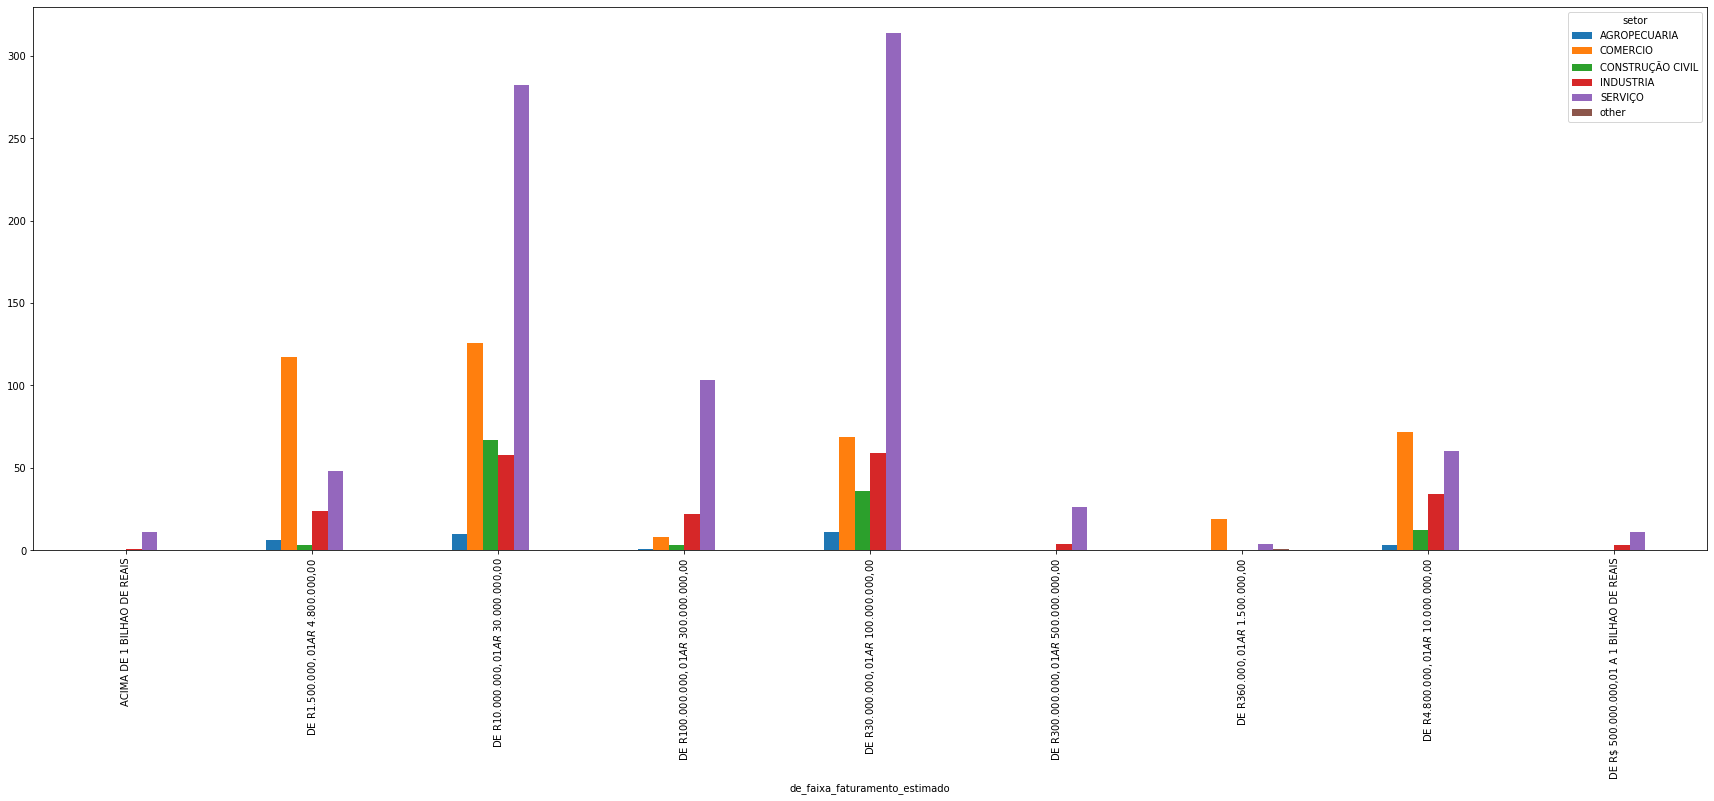

In [160]:
suggestions_gb = suggestions.groupby('de_faixa_faturamento_estimado')
suggestions_gb['setor'].value_counts().unstack().plot.bar(figsize = (30,10))